In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")) + '/lib/')
import time
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader
from lib.net import GNN_Net
from lib.pytorchtools import EarlyStopping, check_gpu

/Users/xiemengtong/anaconda3/envs/Tac-VGNN/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import torch, numpy as np
# from torch_geometric.data import Data

# TIP_NUM = 331  # 你的数据就是 331

# def _infer_T(d, tip_num=TIP_NUM):
#     T = d.x.size(0) // tip_num
#     assert T * tip_num == d.x.size(0), f"node数 {d.x.size(0)} 不是 T×{tip_num}"
#     return T

# def identity_rate(d, tip_num=TIP_NUM):
#     """相邻帧‘身份一致率’（t帧第 i 个节点在 t+1 帧的最近邻是否仍是 i）。理想≥0.95"""
#     T = _infer_T(d, tip_num)
#     XY = d.x[:, :2].view(T, tip_num, 2)              # (T, N, 2)
#     ok = []
#     for t in range(T-1):
#         A, B = XY[t], XY[t+1]                         # (N,2)
#         dist = ((A[:,None]-B[None,:])**2).sum(-1).sqrt()  # (N,N)
#         ok.append((dist.argmin(1) == torch.arange(tip_num)).float().mean().item())
#     return float(np.mean(ok))

# def strip_temporal_edges(d, tip_num=TIP_NUM):
#     """去掉跨帧边（按你的构造：|u-v|==N 的边就是 temporal 边）"""
#     ei = d.edge_index
#     keep = (ei[0] - ei[1]).abs() != tip_num
#     return Data(x=d.x.clone(), edge_index=ei[:, keep].clone(), y=d.y.clone())

# def last_frame_subgraph(d, tip_num=TIP_NUM):
#     """只取最后一帧，恢复成 baseline 的单帧图"""
#     T = _infer_T(d, tip_num)
#     i0, i1 = (T-1)*tip_num, T*tip_num
#     ei = d.edge_index
#     mask = (ei[0] >= i0) & (ei[0] < i1) & (ei[1] >= i0) & (ei[1] < i1)
#     new_ei = (ei[:, mask] - i0).contiguous()
#     return Data(x=d.x[i0:i1].clone(), edge_index=new_ei.clone(), y=d.y.clone())

# # def ensure_t(batch):
# #     """老师代码用 batch.t，当你存的是 y 时，补一个别名即可"""
# #     if not hasattr(batch, "t"):
# #         batch.t = batch.y
# #     return batch


In [ ]:
# ====== 新增：常量 & 工具函数（一次性放在 main() 前）======
TIP_NUM = 331

from torch_geometric.data import Data
import torch
import numpy as np

def _infer_T(d, tip_num=TIP_NUM):
    T = d.x.size(0) // tip_num
    assert T * tip_num == d.x.size(0), f"node数 {d.x.size(0)} 不是 T×{tip_num}"
    return T

def k_last_frames_subgraph_safe(d, k=5, N=TIP_NUM):
    """裁出最后 k 帧；保留所有字段；k==T 时直接返回原样（零差异）。"""
    T = _infer_T(d, N)
    assert 1 <= k <= T, f"k={k} > T={T}"
    if k == T:
        return d  # 完全不动，确保与原样本逐位一致

    i0, i1 = (T - k) * N, T * N
    ei = d.edge_index
    mask = (ei[0] >= i0) & (ei[0] < i1) & (ei[1] >= i0) & (ei[1] < i1)

    d2 = Data()
    # 保留所有键（不丢字段）
    for key, val in d:
        if not torch.is_tensor(val):
            setattr(d2, key, val)
            continue
        if key == "x":
            setattr(d2, "x", val[i0:i1].clone())
        elif key == "edge_index":
            setattr(d2, "edge_index", (val[:, mask] - i0).contiguous())
        else:
            setattr(d2, key, val.clone())
    return d2

def strip_temporal_edges(d, N=TIP_NUM):
    """去掉跨帧边（按你的约定：|u-v|==N）"""
    import copy
    d2 = copy.copy(d)
    ei = d2.edge_index
    keep = (ei[0] - ei[1]).abs() != N
    d2.edge_index = ei[:, keep].contiguous()
    return d2

def last_frame_subgraph(d, N=TIP_NUM):
    """单帧 baseline：只保留最后一帧的节点与帧内边"""
    T = _infer_T(d, N)
    i0, i1 = (T - 1) * N, T * N
    ei = d.edge_index
    m = (ei[0] >= i0) & (ei[0] < i1) & (ei[1] >= i0) & (ei[1] < i1)
    return Data(x=d.x[i0:i1].clone(),
                edge_index=(ei[:, m] - i0).contiguous(),
                y=d.y.clone())

def identity_rate(d, tip_num=TIP_NUM):
    """相邻帧身份一致率（k=1 时返回 1.0 以避免空均值）。"""
    T = _infer_T(d, tip_num)
    if T <= 1:
        return 1.0
    XY = d.x[:, :2].view(T, tip_num, 2)
    ok = []
    for t in range(T - 1):
        A, B = XY[t], XY[t + 1]                         # (N,2)
        dist = ((A[:, None] - B[None, :]) ** 2).sum(-1).sqrt()  # (N,N)
        ok.append((dist.argmin(1) == torch.arange(tip_num)).float().mean().item())
    return float(np.mean(ok))

def ensure_t(batch):
    """有的地方用 batch.t，有的用 batch.y；统一到 batch.t。"""
    if not hasattr(batch, "t") and hasattr(batch, "y"):
        batch.t = batch.y
    return batch


## 1. Define Main Loop for GNN Training

In [ ]:
def main(train_data_dir):

    # === 试验开关 ===
    VARIANT = "orig"          # "orig"（含时序边）|"no_temporal"（去时序边）|"last_frame"（单帧）
    CHECK_IDENTITY = True     # 计算并打印对齐率
    K_FRAMES = 10             # [ADD] 选择要用的帧数（1/5/10/20），k<=生成时 window_size

    ####  1. Training Parameter Setting  ####
    LR = 0.0015
    epoch_num = 200
    batch_size = 2
    patience = 30
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = GNN_Net().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True,
        threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08
    )
    criterion = nn.L1Loss()
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    history = {"train_loss": [], "train_time": [], "val_loss": []}

    ####  2. Dataset Loading  ####
    graph_list_dir = os.path.join(train_data_dir, 'Train_data_list.pt')
    graph_list = torch.load(graph_list_dir)

    gl = torch.load(graph_list_dir, map_location="cpu")
    s = gl[0]
    def get_(z,k):
        return (z[k] if hasattr(z,'keys') and k in z else getattr(z,k) if hasattr(z,k) else None)
    for k in ["x","edge_index","y","pos","edge_attr","temporal_edge_index"]:
        v = get_(s,k)
        print(k, "->", (tuple(v.shape), v.dtype) if torch.is_tensor(v) else type(v))
    if torch.is_tensor(get_(s,"x")) and get_(s,"x").dtype!=torch.float32: print("x -> float32 建议")
    if torch.is_tensor(get_(s,"edge_index")) and get_(s,"edge_index").dtype!=torch.long: print("edge_index -> int64 建议")

    np.random.shuffle(graph_list)
    np.random.shuffle(graph_list)

    train_size = int(len(graph_list) * 0.8)
    val_size   = int(len(graph_list) * 0.2)

    train_dataset = graph_list[:train_size]
    val_dataset   = graph_list[train_size:train_size + val_size]

    print(f"[CHECK] total={len(graph_list)}  train={len(train_dataset)}  val={len(val_dataset)}")

    # [ADD] 先裁成 k 帧（安全版；k==T 时原样返回）
    train_dataset = [k_last_frames_subgraph_safe(d, K_FRAMES, TIP_NUM) for d in train_dataset]
    val_dataset   = [k_last_frames_subgraph_safe(d, K_FRAMES, TIP_NUM) for d in val_dataset]

    # === (可选) 对齐率检查 ===
    if CHECK_IDENTITY:
        import random
        pool = train_dataset if len(train_dataset)>0 else graph_list
        idx = random.sample(range(len(pool)), k=min(20, len(pool)))
        rates = [identity_rate(pool[i], TIP_NUM) for i in idx]
        print(f"[IdentityRate] mean={np.mean(rates):.3f}, min={np.min(rates):.3f}, max={np.max(rates):.3f}")

    # === 选择要跑的变体 ===
    if VARIANT == "orig":
        train_dataset_run = train_dataset
        val_dataset_run   = val_dataset
        print(f"[Variant] RUN = GCN-{K_FRAMES}f-ST (keep temporal edges)")
    elif VARIANT == "no_temporal":
        print("[Variant] strip temporal edges")
        train_dataset_run = [strip_temporal_edges(d, TIP_NUM) for d in train_dataset]
        val_dataset_run   = [strip_temporal_edges(d, TIP_NUM) for d in val_dataset]
        print(f"[Variant] RUN = GCN-{K_FRAMES}f-S (no temporal edges)")
    elif VARIANT == "last_frame":
        print("[Variant] use last frame only (single-frame baseline)")
        train_dataset_run = [last_frame_subgraph(d, TIP_NUM) for d in train_dataset]
        val_dataset_run   = [last_frame_subgraph(d, TIP_NUM) for d in val_dataset]
        print("[Variant] RUN = GCN-1f-S")
    else:
        raise ValueError(f"Unknown VARIANT={VARIANT}")

    # === 建 DataLoader（训练: drop_last=True 防止 BN 遇到 batch=1）===
    train_loader = DataLoader(train_dataset_run, batch_size=batch_size, shuffle=True,  drop_last=True)
    val_loader   = DataLoader(val_dataset_run,   batch_size=batch_size, shuffle=False, drop_last=False)
    print(f"[CHECK] train={len(train_dataset_run)} val={len(val_dataset_run)} "
          f"| train_batches={len(train_loader)} val_batches={len(val_loader)}")

    ####  3. Start Training   ####
    print('Start Train')

    erro = 10000
    pose_2_norm = 1.0
    pose_6_norm = 1.0

    for epoch in range(epoch_num):
        start = time.time()
        train_loss = 0.0
        train_total = 0
        train_batch_num = 0.0

        for i, batch in enumerate(train_loader):
            model.train()
            batch = batch.to(device)

            optimizer.zero_grad()

            outputs = model(batch)

            out_norm   = outputs * torch.tensor([pose_2_norm, pose_6_norm], device=device)
            label_norm = (batch.y).view(outputs.size()) * torch.tensor([pose_2_norm, pose_6_norm], device=device)

            loss = criterion(out_norm, label_norm)
            loss.backward()
            optimizer.step()

            train_loss += loss.cpu().item()
            train_total += 1
            train_batch_num += 1

            if i % 10 == 9:
                progress_bar = '[' + ('=' * ((i + 1) // 10)) + (' ' * ((train_size // 100 - (i + 1)) // 10)) + ']'
                print('\repoch: {:d} training loss: {:.5f} {}'
                      .format(epoch + 1, loss.cpu().item(), progress_bar), end="  ")

        time_cost = time.time() - start
        print('\repoch: {:d} train loss: {:.5f} training time: {:.1f} s/epoch'
              .format(epoch + 1, train_loss / (train_size / batch_size), time_cost), end="  ")

        history["train_loss"].append(train_loss / (train_size / batch_size))
        history["train_time"].append(time_cost)

        ####  4. Start Validation  ####
        model.eval()
        val_batch_num = 0
        val_loss = 0

        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                outputs = model(data)
                out_norm   = outputs * torch.tensor([pose_2_norm, pose_6_norm], device=device)
                label_norm = (data.y).view(outputs.size()) * torch.tensor([pose_2_norm, pose_6_norm], device=device)
                val_loss += criterion(out_norm, label_norm)
                val_batch_num += 1

        history["val_loss"].append(float(val_loss / val_batch_num))
        print(f'Valid Loss: {val_loss / val_batch_num:.5f}', end='  ')

        # 保持你原来的调度习惯（用最后一个 batch 的 loss / val_batch_num）
        scheduler.step(loss.cpu().item() / max(1, val_batch_num))

        LR_ = optimizer.param_groups[0]['lr']
        print('\n' + f'learning rate: {LR_:.8f}', end='  ')

        if (val_loss / val_batch_num) < erro:
            erro = val_loss / val_batch_num
            model_dir = train_data_dir + '/best_model.pth'
            torch.save(model.state_dict(), model_dir)
            print('\n' + 'Saving model......' + '\n')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print('\n' + 'Early stopping')
            break

    print('\n' + 'Finished Training')

    ####  5. Save Training Results  ####
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(history["train_loss"])+1),history["train_loss"], label='Training Loss')
    plt.plot(range(1,len(history["val_loss"])+1),history["val_loss"],label='Validation Loss')
    minposs = history["val_loss"].index(min(history["val_loss"]))+1
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.ylim(0, history["train_loss"][0]*1.2)
    plt.xlim(0, len(history["train_loss"])+1)
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
    fig.savefig(train_data_dir + '/loss_plot' + '.png', bbox_inches='tight')

    # === 评估 MAE (Y / θ) ===
    def eval_mae(loader):
        model.eval()
        sum_y = sum_th = n = 0
        with torch.no_grad():
            for batch in loader:
                batch = ensure_t(batch).to(device)
                out = model(batch)
                tgt = batch.t.view(out.size()).to(device)
                # 若训练时做了缩放，这里保持一致（你当前是 1）
                out = out * torch.tensor([pose_2_norm, pose_6_norm], device=device)
                tgt = tgt * torch.tensor([pose_2_norm, pose_6_norm], device=device)
                err = (out - tgt).abs()
                sum_y  += float(err[:,0].sum().cpu())
                sum_th += float(err[:,1].sum().cpu())
                n      += err.size(0)
        return (sum_y/max(1,n), sum_th/max(1,n))

    mae_y_tr, mae_th_tr = eval_mae(train_loader)
    mae_y_va, mae_th_va = eval_mae(val_loader)
    print(f"\n[MAE] Train: Y={mae_y_tr:.4f} mm | θ={mae_th_tr:.4f} °")
    print(f"[MAE] Valid: Y={mae_y_va:.4f} mm | θ={mae_th_va:.4f} °")


In [3]:
def main(train_data_dir):

     # === 试验开关 ===
    VARIANT = "orig"          # 可选: "orig"（原始含temporal边）、"no_temporal"（去掉跨帧边）、"last_frame"（单帧baseline）
    CHECK_IDENTITY = True     # 计算并打印对齐率
    K_FRAMES = 10           # 手动改 1/5/10/20 试
    MODE     = "ST"         # "S"=无时序; "ST"=有时序（保留跨帧边）



    ####  1. Training Parameter Setting  ####

    LR = 0.0015  ## learning rate

    epoch_num = 200  ## epoch number

    batch_size = 2  ## batch size

    patience = 30  ## early_stopping patience

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  ## device defination

    model = GNN_Net().to(device)  ## GNN model loading

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)  ## optimizer setting

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True,
                                                           threshold=0.001, threshold_mode='rel',
                                                           cooldown=0, min_lr=0, eps=1e-08)  ## learning rate adapter setting

    criterion = nn.L1Loss()  ## MAE Loss

    early_stopping = EarlyStopping(patience=patience, verbose=True)  ## initialize the early_stopping object

    history = {
        "train_loss": [],
        "train_time": [],
        "val_loss": [],
    }  ## training history recording


    ####  2. Dataset Loading  ####

    graph_list_dir = os.path.join(train_data_dir, 'Train_data_list.pt')  ## train/val set dir
    graph_list = torch.load(graph_list_dir)  ## load voronoi graph dataset
    

    gl = torch.load(graph_list_dir, map_location="cpu")  # 或你的绝对路径

    s = gl[0]
    def get(z,k):
        return (z[k] if hasattr(z,'keys') and k in z else getattr(z,k) if hasattr(z,k) else None)

    for k in ["x","edge_index","y","pos","edge_attr","temporal_edge_index"]:
        v = get(s,k)
        print(k, "->", (tuple(v.shape), v.dtype) if torch.is_tensor(v) else type(v))

    # dtype 提示
    if torch.is_tensor(get(s,"x")) and get(s,"x").dtype!=torch.float32: print("x -> float32 建议")
    if torch.is_tensor(get(s,"edge_index")) and get(s,"edge_index").dtype!=torch.long: print("edge_index -> int64 建议")

    
    
    
    
    
    np.random.shuffle(graph_list)  ## shuffle the dataset
    np.random.shuffle(graph_list)  ## shuffle the dataset

    train_size = int(len(graph_list) * 0.8)   ## train set size
    val_size = int(len(graph_list) * 0.2)   ## validation set size

    train_dataset = graph_list[:train_size]  
    val_dataset = graph_list[train_size:train_size + val_size] 
    
    print(f"[CHECK] total={len(graph_list)}  train={len(train_dataset)}  val={len(val_dataset)}")
    
    
    
    
    
        # === (可选) 对齐率检查 ===
    if CHECK_IDENTITY:
        import random
        pool = train_dataset if len(train_dataset)>0 else graph_list
        idx = random.sample(range(len(pool)), k=min(20, len(pool)))
        rates = [identity_rate(pool[i], TIP_NUM) for i in idx]
        print(f"[IdentityRate] mean={np.mean(rates):.3f}, min={np.min(rates):.3f}, max={np.max(rates):.3f}")

    # === 选择要跑的变体 ===
    if VARIANT == "orig":
        train_dataset_run = train_dataset
        val_dataset_run   = val_dataset
    elif VARIANT == "no_temporal":
        print("[Variant] strip temporal edges")
        train_dataset_run = [strip_temporal_edges(d, TIP_NUM) for d in train_dataset]
        val_dataset_run   = [strip_temporal_edges(d, TIP_NUM) for d in val_dataset]
    elif VARIANT == "last_frame":
        print("[Variant] use last frame only (single-frame baseline)")
        train_dataset_run = [last_frame_subgraph(d, TIP_NUM) for d in train_dataset]
        val_dataset_run   = [last_frame_subgraph(d, TIP_NUM) for d in val_dataset]
    else:
        raise ValueError(f"Unknown VARIANT={VARIANT}")

   
   
   
   
   
   # === 建 DataLoader（训练: drop_last=True 防止 BN 遇到 batch=1）===

    train_loader = DataLoader(train_dataset_run, batch_size=batch_size, shuffle=True,  drop_last=True)
    val_loader   = DataLoader(val_dataset_run,   batch_size=batch_size,   shuffle=False, drop_last=False)
    print(f"[CHECK] train={len(train_dataset_run)} val={len(val_dataset_run)} "
          f"| train_batches={len(train_loader)} val_batches={len(val_loader)}")

    ####  3. Start Training   ####
    
    print('Start Train')
    
    erro = 10000  ## initialise error value to max
    pose_2_norm = 1  ## pose_2 norm scale
    pose_6_norm = 1  ## pose_6 norm scale

    for epoch in range(epoch_num):  ## start an epoch...
        
        start = time.time()
        train_loss = 0.0
        train_total = 0
        train_batch_num = 0.0

        ## Train loop
        for i, batch in enumerate(train_loader):  ## start a batch...

            model.train()  ## set as traning mode
            
            batch = batch.to(device)  ## load batch data

            optimizer.zero_grad()  ## gradiant clear

            outputs = model(batch)  ## GNN model prediction output

            out_norm = outputs*torch.tensor([pose_2_norm,pose_6_norm]).to(device) ## output normalization

            label_norm = (batch.y).view(outputs.size())*torch.tensor([pose_2_norm,pose_6_norm]).to(device)  ## target normalization

            loss = criterion(out_norm, label_norm)  ## calculate loss    

            loss.backward()  ## backward

            optimizer.step()  ## parameter update bt optimizer

            train_loss += loss.cpu().item()  ## Loss add

            train_total += 1  ## update train times 

            train_batch_num += 1  ## update batch number 

            if i % 10 == 9:
                progress_bar = '[' + ('=' * ((i + 1) // 10)) + (' ' * ((train_size // 100 - (i + 1)) // 10)) + ']'
                print('\repoch: {:d} training loss: {:.5f} {}'
                      .format(epoch + 1, loss.cpu().item(), progress_bar), end="  ")  ## live Loss

        time_cost = time.time() - start
        
        print('\repoch: {:d} train loss: {:.5f} training time: {:.1f} s/epoch'
              .format(epoch + 1, train_loss / (train_size / batch_size), time_cost), end="  ")  # current epoch avrage Loss of each batch

        history["train_loss"].append(train_loss / (train_size / batch_size))  ## record train loss
        history["train_time"].append(time_cost)   ## record train time cost


        ####  4. Start Validation  ####

        model.eval()  ## set as evaluation mode, to make traning smoother and faster, may just note and ignore it

        val_batch_num = 0
        val_loss = 0
        
        ## Validation loop
        with torch.no_grad():  ## stop gradiant update

            for data in val_loader: 

                data = data.to(device)  ## load batch data

                outputs = model(data)  ## GNN model prediction output

                out_norm = outputs*torch.tensor([pose_2_norm, pose_6_norm]).to(device)

                label_norm = (data.y).view(outputs.size())*torch.tensor([pose_2_norm,pose_6_norm]).to(device)

                val_loss += criterion(out_norm, label_norm)  ## Valid Loss

                val_batch_num += 1

        history["val_loss"].append(float(val_loss / val_batch_num))  ## record val loss

        print(f'Valid Loss: {val_loss / val_batch_num:.5f}', end='  ')  ## val loss

        scheduler.step(loss.cpu().item() / val_batch_num)  # learning rate update

        LR_ = optimizer.param_groups[0]['lr']  ## new learning rate

        print('\n' + f'learning rate: {LR_:.8f}', end='  ')  

        if (val_loss / val_batch_num) < erro:  ## save the best model from all epoch

            erro = val_loss / val_batch_num

            model_dir = train_data_dir + '/best_model.pth'

            torch.save(model.state_dict(), model_dir)   

            print('\n' + 'Saving model......' + '\n')
            
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print('\n' + 'Early stopping')
            break

    # load the last checkpoint with the best model
    # model.load_state_dict(torch.load('checkpoint.pt'))
    
    print('\n' + 'Finished Training')
    

    ####  5. Save Training Results  ####
    
    ## visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(history["train_loss"])+1),history["train_loss"], label='Training Loss')
    plt.plot(range(1,len(history["val_loss"])+1),history["val_loss"],label='Validation Loss')
    
    ## find position of lowest validation loss
    minposs = history["val_loss"].index(min(history["val_loss"]))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, history["train_loss"][0]*1.2) # consistent scale
    plt.xlim(0, len(history["train_loss"])+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    ## save the loss plot
    fig.savefig(train_data_dir + '/loss_plot' + '.png', bbox_inches='tight')

## 2. Run Main Loop for GNN Training

In [4]:
train_data_dir = r'../result/train'  ## train data dir

#check_gpu(0)  ## set gpu device id

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  ## allow duplicate load DLL

if __name__ == "__main__":
    
    main(train_data_dir)

x -> ((6620, 3), torch.float32)
edge_index -> ((2, 43160), torch.int64)
y -> ((2,), torch.float32)
pos -> <class 'NoneType'>
edge_attr -> <class 'NoneType'>
temporal_edge_index -> <class 'NoneType'>
[CHECK] total=108  train=86  val=21
[IdentityRate] mean=0.885, min=0.747, max=0.975
[CHECK] train=86 val=21 | train_batches=43 val_batches=11
Start Train


/Users/xiemengtong/anaconda3/envs/Tac-VGNN/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


epoch: 1 train loss: 4.56783 training time: 13.4 s/epoch  Valid Loss: 4.20469  
learning rate: 0.00150000  
Saving model......

Validation loss decreased (inf --> 46.251553).  Saving model ...
epoch: 2 train loss: 4.19385 training time: 12.9 s/epoch  Valid Loss: 3.76433  
learning rate: 0.00150000  
Saving model......

Validation loss decreased (46.251553 --> 41.407581).  Saving model ...
epoch: 3 train loss: 4.06313 training time: 13.0 s/epoch  Valid Loss: 3.40204  
learning rate: 0.00150000  
Saving model......

Validation loss decreased (41.407581 --> 37.422401).  Saving model ...
epoch: 4 train loss: 3.77164 training time: 14.5 s/epoch  Valid Loss: 3.55247  
learning rate: 0.00150000  EarlyStopping counter: 1 out of 30

epoch: 5 train loss: 3.56160 training time: 15.2 s/epoch  Valid Loss: 3.31654  
learning rate: 0.00150000  
Saving model......

Validation loss decreased (37.422401 --> 36.481976).  Saving model ...
epoch: 6 train loss: 4.26633 training time: 16.5 s/epoch  Valid Los

In [6]:

# ====== 常量 / 小工具 ======
TIP_NUM = 331

def _infer_T(d, tip_num=TIP_NUM):
    T = d.x.size(0) // tip_num
    assert T * tip_num == d.x.size(0), f"node数 {d.x.size(0)} 不是 T×{tip_num}"
    return T

def identity_rate(d, tip_num=TIP_NUM):
    """相邻帧‘身份一致率’（t帧第 i 个节点在 t+1 帧的最近邻是否仍是 i）。"""
    T = _infer_T(d, tip_num)
    XY = d.x[:, :2].view(T, tip_num, 2)
    ok = []
    for t in range(T-1):
        A, B = XY[t], XY[t+1]                               # (N,2)
        dist = ((A[:,None]-B[None,:])**2).sum(-1).sqrt()    # (N,N)
        ok.append((dist.argmin(1) == torch.arange(tip_num)).float().mean().item())
    return float(np.mean(ok))

def strip_temporal_edges(d, N=TIP_NUM):
    """去掉跨帧边（按你的构造：|u-v|==N 的边就是 temporal 边）"""
    import copy
    d2 = copy.copy(d)
    ei = d2.edge_index
    keep = (ei[0]-ei[1]).abs()!=N
    d2.edge_index = ei[:, keep]
    return d2

def last_frame_subgraph(d, N=TIP_NUM):
    """只取最后一帧，单帧基线"""
    T = _infer_T(d, N)
    i0, i1 = (T-1)*N, T*N
    ei = d.edge_index
    mask = (ei[0] >= i0) & (ei[0] < i1) & (ei[1] >= i0) & (ei[1] < i1)
    new_ei = (ei[:, mask] - i0).contiguous()
    from torch_geometric.data import Data
    return Data(x=d.x[i0:i1].clone(), edge_index=new_ei.clone(), y=d.y.clone())

def k_last_frames_subgraph(d, k=5, N=TIP_NUM):
    """把一个 20 帧样本裁成‘最后 k 帧’（保留这 k 帧内部的空间/时序边）"""
    from torch_geometric.data import Data
    T = _infer_T(d, N)
    assert 1 <= k <= T
    i0, i1 = (T-k)*N, T*N
    ei = d.edge_index
    m = (ei[0]>=i0)&(ei[0]<i1)&(ei[1]>=i0)&(ei[1]<i1)
    return Data(x=d.x[i0:i1].clone(), edge_index=(ei[:,m]-i0).contiguous(), y=d.y.clone())

def ensure_t(batch):
    """有的代码用 batch.t，有的用 batch.y，这里统一一下（可选）。"""
    if not hasattr(batch, "t") and hasattr(batch, "y"):
        batch.t = batch.y
    return batch

# 兜底版 EarlyStopping（你项目里若已实现，会自动覆盖这个）
# class EarlyStopping:
#     def __init__(self, patience=20, verbose=False):
#         self.patience = patience
#         self.counter = 0
#         self.best = None
#         self.early_stop = False
#         self.verbose = verbose
#     def __call__(self, val_loss, model):
#         score = float(val_loss)
#         if self.best is None or score < self.best - 1e-12:
#             self.best = score
#             self.counter = 0
#         else:
#             self.counter += 1
#             if self.verbose:
#                 print(f"EarlyStopping counter: {self.counter}/{self.patience}")
#             if self.counter >= self.patience:
#                 self.early_stop = True

# ====== 你的 GNN 模型 ======
# 这里假定你已有老师提供的 GNN_Net 定义（from lib.net import GNN_Net 等）
# 如果是自定义路径，请按你的工程导入。
# from lib.net import GNN_Net  # <-- 按你项目的真实路径导入

# ====== 训练主函数 ======
def main(train_data_dir):

    # === 试验开关 ===
    VARIANT = "orig"    # 可选: "orig"(含时序边) / "no_temporal"(去时序边) / "last_frame"(单帧基线)
    CHECK_IDENTITY = True
    K_FRAMES = 20       # 手动改 1/5/10/20 试
    MODE = "ST"         # "S"=无时序 ; "ST"=有时序（仅当 VARIANT 不是三选一时才生效）

    # === 训练参数 ===
    LR = 0.0015
    epoch_num = 200
    batch_size = 2
    patience = 30
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = GNN_Net().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True,
        threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08
    )
    criterion = nn.L1Loss()
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    history = {"train_loss": [], "train_time": [], "val_loss": []}

    # === 载入数据 ===
    graph_list_path = os.path.join(train_data_dir, 'Train_data_list.pt')
    graph_list = torch.load(graph_list_path, map_location="cpu")

    # 简要检查首个样本
    s = graph_list[0]
    def _get(z,k):
        return (z[k] if hasattr(z,'keys') and k in z else getattr(z,k) if hasattr(z,k) else None)
    for k in ["x","edge_index","y","pos","edge_attr","temporal_edge_index"]:
        v = _get(s,k)
        print(k, "->", (tuple(v.shape), v.dtype) if torch.is_tensor(v) else type(v))

    np.random.shuffle(graph_list)
    train_size = int(len(graph_list) * 0.8)
    val_size   = len(graph_list) - train_size
    train_dataset = graph_list[:train_size]
    val_dataset   = graph_list[train_size:]

    print(f"[CHECK] total={len(graph_list)}  train={len(train_dataset)}  val={len(val_dataset)}")

    # === 选择有效 k 与模式 ===
    # 允许用 VARIANT 快速切换，也支持 K_FRAMES/MODE 手动配
    if VARIANT == "last_frame":
        eff_k, eff_mode = 1, "S"
    elif VARIANT == "orig":
        eff_k, eff_mode = K_FRAMES, "ST"
    elif VARIANT == "no_temporal":
        eff_k, eff_mode = K_FRAMES, "S"
    else:
        eff_k, eff_mode = K_FRAMES, MODE

    # 裁成 k 帧
    train_k = [k_last_frames_subgraph(d, eff_k, TIP_NUM) for d in train_dataset]
    val_k   = [k_last_frames_subgraph(d, eff_k, TIP_NUM) for d in val_dataset]

    # 去/保留时序边
    if eff_mode == "S":
        train_dataset_run = [strip_temporal_edges(d, TIP_NUM) for d in train_k]
        val_dataset_run   = [strip_temporal_edges(d, TIP_NUM) for d in val_k]
        print(f"[Variant] RUN = GCN-{eff_k}f-S (no temporal edges)")
    else:
        train_dataset_run, val_dataset_run = train_k, val_k
        print(f"[Variant] RUN = GCN-{eff_k}f-ST (keep temporal edges)")

    # === 对齐率（可选）===
    if CHECK_IDENTITY:
        import random
        pool = train_dataset_run if len(train_dataset_run)>0 else graph_list
        idx = random.sample(range(len(pool)), k=min(20, len(pool)))
        rates = [identity_rate(pool[i], TIP_NUM) for i in idx]
        print(f"[IdentityRate] mean={np.mean(rates):.3f}, min={np.min(rates):.3f}, max={np.max(rates):.3f}")

    # === DataLoader ===
    train_loader = DataLoader(train_dataset_run, batch_size=batch_size, shuffle=True,  drop_last=True)
    val_loader   = DataLoader(val_dataset_run,   batch_size=batch_size, shuffle=False, drop_last=False)
    print(f"[CHECK] train={len(train_dataset_run)} val={len(val_dataset_run)} "
          f"| train_batches={len(train_loader)} val_batches={len(val_loader)}")

    # === 训练 ===
    print('Start Train')
    best_val = float('inf')
    pose_2_norm = 1.0
    pose_6_norm = 1.0

    for epoch in range(1, epoch_num+1):
        t0 = time.time()
        model.train()
        train_loss_sum = 0.0

        for i, batch in enumerate(train_loader):
            batch = ensure_t(batch).to(device)
            optimizer.zero_grad()
            outputs = model(batch)

            out_norm   = outputs * torch.tensor([pose_2_norm, pose_6_norm], device=device)
            label_norm = batch.t.view(outputs.size()) * torch.tensor([pose_2_norm, pose_6_norm], device=device)

            loss = criterion(out_norm, label_norm)
            loss.backward()
            optimizer.step()

            train_loss_sum += float(loss.detach().cpu())
            if (i+1) % 10 == 0:
                print(f"\repoch: {epoch:03d} training loss: {float(loss.detach().cpu()):.5f}", end="  ")

        time_cost = time.time() - t0
        train_loss_avg = train_loss_sum / max(1, len(train_loader))
        print(f"\repoch: {epoch:03d} train loss: {train_loss_avg:.5f}  time: {time_cost:.1f}s", end="  ")

        history["train_loss"].append(train_loss_avg)
        history["train_time"].append(time_cost)

        # === 验证 ===
        model.eval()
        val_loss_sum = 0.0
        val_batch_num = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = ensure_t(batch).to(device)
                outputs = model(batch)
                out_norm   = outputs * torch.tensor([pose_2_norm, pose_6_norm], device=device)
                label_norm = batch.t.view(outputs.size()) * torch.tensor([pose_2_norm, pose_6_norm], device=device)
                val_loss_sum += float(criterion(out_norm, label_norm).detach().cpu())
                val_batch_num += 1

        val_loss_avg = val_loss_sum / max(1, val_batch_num)
        history["val_loss"].append(val_loss_avg)
        print(f"Valid Loss: {val_loss_avg:.5f}", end="  ")

        scheduler.step(val_loss_avg)
        LR_ = optimizer.param_groups[0]['lr']
        print(f"\nlearning rate: {LR_:.8f}", end="  ")

        # 保存最佳
        if val_loss_avg < best_val - 1e-12:
            best_val = val_loss_avg
            model_dir = os.path.join(train_data_dir, 'best_model.pth')
            torch.save(model.state_dict(), model_dir)
            print('\nSaving model......\n')

        # 早停
        early_stopping(val_loss_avg, model)
        if early_stopping.early_stop:
            print('\nEarly stopping')
            break

    print('\nFinished Training')

    # === 画曲线 ===
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1, len(history["train_loss"])+1), history["train_loss"], label='Training Loss')
    plt.plot(range(1, len(history["val_loss"])+1),   history["val_loss"],   label='Validation Loss')
    if len(history["val_loss"])>0:
        minpos = int(np.argmin(history["val_loss"]))+1
        plt.axvline(minpos, linestyle='--', color='r', label='Early Stopping Checkpoint')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.grid(True); plt.legend(); plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(train_data_dir, 'loss_plot.png'), bbox_inches='tight')

    # === 评估 MAE (Y / θ) ===
    def eval_mae(loader):
        model.eval()
        sum_y = sum_th = n = 0
        with torch.no_grad():
            for batch in loader:
                batch = ensure_t(batch).to(device)
                out = model(batch)
                tgt = batch.t.view(out.size()).to(device)
                # 若你训练时做了缩放，这里做相同缩放或反缩放
                # out = out * torch.tensor([pose_2_norm, pose_6_norm], device=device)
                # tgt = tgt * torch.tensor([pose_2_norm, pose_6_norm], device=device)
                err = (out - tgt).abs()
                sum_y  += float(err[:,0].sum().cpu())
                sum_th += float(err[:,1].sum().cpu())
                n      += err.size(0)
        return (sum_y/max(1,n), sum_th/max(1,n))

    mae_y_tr, mae_th_tr = eval_mae(train_loader)
    mae_y_va, mae_th_va = eval_mae(val_loader)
    print(f"\n[MAE] Train: Y={mae_y_tr:.4f} mm | θ={mae_th_tr:.4f} °")
    print(f"[MAE] Valid: Y={mae_y_va:.4f} mm | θ={mae_th_va:.4f} °")



x -> ((6620, 3), torch.float32)
edge_index -> ((2, 42827), torch.int64)
y -> ((2,), torch.float32)
pos -> <class 'NoneType'>
edge_attr -> <class 'NoneType'>
temporal_edge_index -> <class 'NoneType'>
[CHECK] total=108  train=86  val=22
[Variant] RUN = GCN-20f-ST (keep temporal edges)
[IdentityRate] mean=0.871, min=0.769, max=0.933
[CHECK] train=86 val=22 | train_batches=43 val_batches=11
Start Train
epoch: 001 train loss: 4.35306  time: 12.0s  Valid Loss: 4.08158  
learning rate: 0.00150000  
Saving model......

Validation loss decreased (inf --> 4.081582).  Saving model ...
epoch: 002 train loss: 4.01858  time: 12.9s  Valid Loss: 3.68182  
learning rate: 0.00150000  
Saving model......

Validation loss decreased (4.081582 --> 3.681821).  Saving model ...
epoch: 003 train loss: 3.73198  time: 12.8s  Valid Loss: 3.08317  
learning rate: 0.00150000  
Saving model......

Validation loss decreased (3.681821 --> 3.083170).  Saving model ...
epoch: 004 train loss: 3.96624  time: 13.5s  Valid 

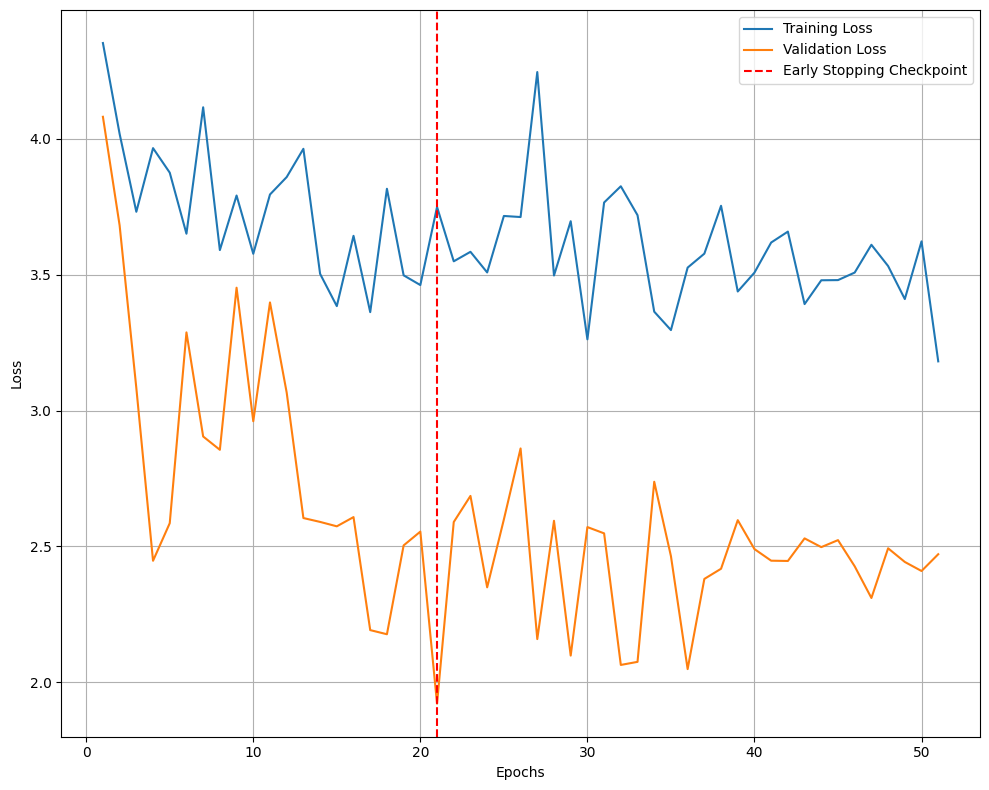


[MAE] Train: Y=1.1023 mm | θ=4.4576 °
[MAE] Valid: Y=1.0525 mm | θ=3.8906 °


In [7]:
# 直接运行
if __name__ == "__main__":
    # 例：train_data_dir = "/path/to/result/train"
    train_data_dir = "../result/train"
    os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
    main(train_data_dir)


## Test

In [ ]:
# ===== 在训练循环和曲线绘制之后，加：测试集评估 =====
# 假设测试集是生成时保存的: result/test/Test_data_list.pt
test_data_path = os.path.join(os.path.dirname(train_data_dir), '..', 'test', 'Test_data_list.pt')
test_data_path = os.path.abspath(test_data_path)

if os.path.exists(test_data_path):
    print(f"\n[TEST] loading {test_data_path}")
    test_list = torch.load(test_data_path, map_location="cpu")

    # 和训练/验证完全一致的 k / 模式（非常重要，保持公平）
    test_k = [k_last_frames_subgraph(d, eff_k, TIP_NUM) for d in test_list]
    if eff_mode == "S":
        test_run = [strip_temporal_edges(d, TIP_NUM) for d in test_k]
        print(f"[TEST] Eval = GCN-{eff_k}f-S")
    else:
        test_run = test_k
        print(f"[TEST] Eval = GCN-{eff_k}f-ST")

    test_loader = DataLoader(test_run, batch_size= batch_size, shuffle=False, drop_last=False)

    # 用你训练时保存的最佳权重（best_model.pth）
    best_model_path = os.path.join(train_data_dir, 'best_model.pth')
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        model.to(device).eval()

    # 直接复用你上面的 eval_mae(loader)
    mae_y_te, mae_th_te = eval_mae(test_loader)
    print(f"[MAE] Test:  Y={mae_y_te:.4f} mm | θ={mae_th_te:.4f} °")
else:
    print("\n[TEST] 未找到测试集 .pt（跳过测试评估）。")
